# Image anomaly detection with deep learning autoencoder

In [158]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [159]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy

In [160]:
aesaveDir = "./aemnist/"
if not os.path.isdir(aesaveDir):
    os.makedirs(aesaveDir)
saveDir = "./mnist/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [161]:
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

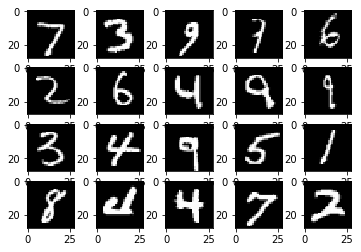

In [162]:
a = 0
for i in range(len(x_test[:10000])):
    if i % 500 == 0:
        a += 1
        plt.subplot(4,5,a)
        plt.imshow(x_test[i], cmap=plt.get_cmap('gray'))
plt.show()

In [163]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [164]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [165]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [166]:
batch_size = 128
epochs = 100

In [167]:
autoEnc = Sequential()
autoEnc.add(Conv2D(32, kernel_size=(3,3), padding='same',
                  input_shape=input_shape))
autoEnc.add(BatchNormalization())
autoEnc.add(Activation("relu"))
autoEnc.add(MaxPooling2D((2, 2), padding='same'))

autoEnc.add(Conv2D(16, kernel_size=(3,3), padding='same'))
autoEnc.add(BatchNormalization())
autoEnc.add(Activation("relu"))
autoEnc.add(MaxPooling2D((2, 2), padding='same'))

autoEnc.add(Conv2D(8, kernel_size=(3,3), padding='same'))
autoEnc.add(BatchNormalization())
autoEnc.add(Activation("relu"))
autoEnc.add(MaxPooling2D((2, 2), padding='same'))


autoEnc.add(Conv2D(8, kernel_size=(3,3), padding='same'))
autoEnc.add(BatchNormalization())
autoEnc.add(Activation("relu"))
autoEnc.add(UpSampling2D((2, 2)))

autoEnc.add(Conv2D(16, kernel_size=(3,3), padding='same'))
autoEnc.add(BatchNormalization())
autoEnc.add(Activation("relu"))
autoEnc.add(UpSampling2D((2, 2)))

autoEnc.add(Conv2D(32, kernel_size=(3,3)))
autoEnc.add(BatchNormalization())
autoEnc.add(Activation("relu"))
autoEnc.add(UpSampling2D((2, 2)))

autoEnc.add(Conv2D(1, kernel_size=(3,3), padding='same'))
autoEnc.add(BatchNormalization())
autoEnc.add(Activation("sigmoid"))

In [168]:
autoEnc.compile(loss=keras.losses.mean_squared_error,
                optimizer=keras.optimizers.Adam())

In [169]:
# get the newest model file
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model
autoEnc = getNewestModel(autoEnc, aesaveDir)

In [170]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(aesaveDir, 'MNIST_AE.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [171]:
autoEnc.fit(x_train, x_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=[es_cb, cp_cb],
            validation_data=(x_test, x_test),
            shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 93s 2ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 2/100
60000/60000 [==============================] - 88s 1ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 3/100
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 4/100
60000/60000 [==============================] - 88s 1ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 00004: early stopping


In [172]:
autoEnc = getNewestModel(autoEnc, aesaveDir)

In [173]:
mnistAE = []
for i in range(len(x_test)):
    aeScore = autoEnc.evaluate(np.array([x_test[i]]), np.array([x_test[i]]), verbose=0)
    mnistAE.append(aeScore)

In [174]:
aePred = autoEnc.predict(x_test)

In [268]:
cc = 0
for i in range(len(aePred)):
    a = mnistAE[i] / np.average(x_test[i])
    if a > 0.15:
        cc += 1

In [269]:
print("Ratio of detected anomaly within real data: {0}".format(cc/len(x_test)))

Ratio of detected anomaly within real data: 0.0173


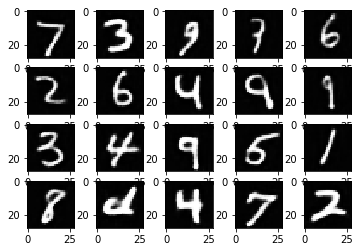

In [177]:
aePredR = aePred.reshape(aePred.shape[0], img_rows, img_cols)
a = 0
for i in range(len(aePredR[:10000])):
    if i % 500 == 0:
        a += 1
        plt.subplot(4,5,a)
        plt.imshow(aePredR[i], cmap=plt.get_cmap('gray'))
plt.show()

In [178]:
# generate an image with one line
def drawLine():
    leftFrom = np.random.randint(28)
    rightTo = np.random.randint(28)
    darkness = np.random.randint(200,255)
    lineSize = np.random.randint(1,4)
    img = np.zeros((28,28), np.uint8)
    img = cv2.line(img, (0,leftFrom), (27, rightTo), (darkness), lineSize)
    return img

In [179]:
# generate an image with two lines
def drawTwoLines():
    img = np.zeros((28,28), np.uint8)
    for i in range(2):
        leftFrom = np.random.randint(28)
        rightTo = np.random.randint(28)
        darkness = np.random.randint(200,255)
        lineSize = np.random.randint(1,4)
        img = cv2.line(img, (0,leftFrom), (27, rightTo), (darkness), lineSize)
    return img

In [180]:
# generate an image with multiple lines
def drawMultiLines():
    numLines = np.random.randint(3,8)
    img = np.zeros((28,28), np.uint8)
    for i in range(numLines):
        s1 = np.random.randint(0,10)
        s2 = np.random.randint(0,10)
        e1 = np.random.randint(18,28)
        e2 = np.random.randint(18,28)
        darkness = np.random.randint(200,255)
        lineSize = np.random.randint(1,4)
        img = cv2.line(img, (s1,s2), (e1,e2), (darkness), lineSize)
    return img

In [181]:
# generate an image with lines drawn on a x_train image
def drawLinesOnImg():
    numLines = np.random.randint(2,4)
    imn = np.random.randint(len(x_train))
    img = copy.deepcopy(x_train[imn])
    img *= 255
    img = img.reshape(img_rows, img_cols)
    for i in range(numLines):
        s1 = np.random.randint(0,10)
        s2 = np.random.randint(0,10)
        e1 = np.random.randint(18,28)
        e2 = np.random.randint(18,28)
        darkness = np.random.randint(200,255)
        lineSize = np.random.randint(1,3)
        img = cv2.line(img, (s1,s2), (e1,e2), (darkness), lineSize)
    return img

In [260]:
anomImg = np.array([drawLine() for i in range(2500)])
anomImg2 = np.array([drawTwoLines() for i in range(2500)])
anomImg3 = np.array([drawMultiLines() for i in range(2500)])
anomImg4 = np.array([drawLinesOnImg() for i in range(2500)])
anomImg = np.vstack((np.vstack((np.vstack((anomImg,anomImg2)),anomImg3)),anomImg4))
anomImg.shape

(10000, 28, 28)

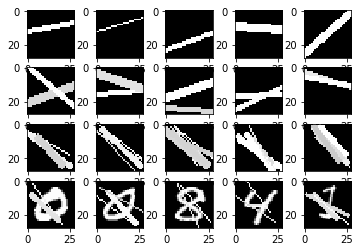

In [261]:
a = 0
for i in range(len(anomImg)):
    if i % 500 == 0:
        a += 1
        plt.subplot(4,5,a)
        plt.imshow(anomImg[i], cmap=plt.get_cmap('gray'))
plt.show()

In [262]:
anomImgR = anomImg.reshape(anomImg.shape[0], img_rows, img_cols, 1)
anomImgR = anomImgR.astype('float32')
anomImgR /= 255

In [263]:
anomEvl = []
for i in anomImgR:
    anomScore = autoEnc.evaluate(np.array([i]), np.array([i]), verbose=0)
    anomEvl.append(anomScore)

In [270]:
ac = 0
for i in range(len(anomImgR)):
    a = anomEvl[i] / np.average(anomImgR[i])
    if a > 0.15:
        ac += 1

In [271]:
print("Ratio of detected anomaly within false data: {0}".format(ac/len(anomImgR)))

Ratio of detected anomaly within false data: 0.9799


In [266]:
anomAE = autoEnc.predict(anomImgR)
anomAER = anomAE.reshape(anomAE.shape[0], img_rows, img_cols)

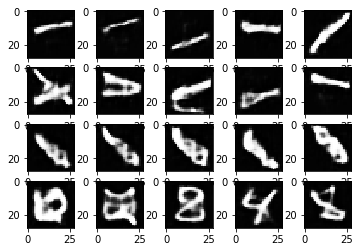

In [267]:
a = 0
for i in range(len(anomAER)):
    if i % 500 == 0:
        a += 1
        plt.subplot(4,5,a)
        plt.imshow(anomAER[i], cmap=plt.get_cmap('gray'))
plt.show()

In [272]:
batch_size = 128
epochs = 100

In [273]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [274]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [275]:
model = getNewestModel(model, saveDir)

In [276]:
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = os.path.join(saveDir, 'MNIST.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [131]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[es_cb, cp_cb],
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 53s 879us/step - loss: 0.0451 - acc: 0.9859 - val_loss: 0.0339 - val_acc: 0.9889
Epoch 2/100
60000/60000 [==============================] - 52s 863us/step - loss: 0.0397 - acc: 0.9872 - val_loss: 0.0353 - val_acc: 0.9883
Epoch 3/100
60000/60000 [==============================] - 51s 853us/step - loss: 0.0364 - acc: 0.9888 - val_loss: 0.0314 - val_acc: 0.9902
Epoch 4/100
60000/60000 [==============================] - 52s 870us/step - loss: 0.0336 - acc: 0.9889 - val_loss: 0.0318 - val_acc: 0.9894
Epoch 5/100
60000/60000 [==============================] - 51s 848us/step - loss: 0.0281 - acc: 0.9910 - val_loss: 0.0303 - val_acc: 0.9908
Epoch 6/100
60000/60000 [==============================] - 52s 860us/step - loss: 0.0291 - acc: 0.9909 - val_loss: 0.0263 - val_acc: 0.9916
Epoch 7/100
60000/60000 [==============================] - 52s 872us/step - loss: 0.0252 - acc: 0.9915 - val_l

In [277]:
model = getNewestModel(model, saveDir)

In [278]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0263153266224
Test accuracy: 0.9916


In [301]:
er1 = 0
for i in range(len(x_test)):
    aeEv = autoEnc.evaluate(np.array([x_test[i]]), np.array([x_test[i]]), verbose=0)
    a = aeEv / np.average(x_test[i])
    if a <= 0.15:
        if i % 500 == 0:
            print("O testdata: {0}\tpred: {1}\ttruth: {2}".
                  format(i, np.argmax(model.predict(np.array([x_test[i]]))), np.argmax(y_test[i])))
    else:
        er1 += 1
        if i % 500 == 0:
            print("X testdata: NG")

O testdata: 0	pred: 7	truth: 7
O testdata: 500	pred: 3	truth: 3
O testdata: 1000	pred: 9	truth: 9
O testdata: 1500	pred: 7	truth: 7
O testdata: 2000	pred: 6	truth: 6
O testdata: 2500	pred: 2	truth: 2
O testdata: 3000	pred: 6	truth: 6
O testdata: 3500	pred: 4	truth: 4
O testdata: 4000	pred: 9	truth: 9
O testdata: 4500	pred: 9	truth: 9
O testdata: 5000	pred: 3	truth: 3
O testdata: 5500	pred: 4	truth: 4
O testdata: 6000	pred: 9	truth: 9
O testdata: 6500	pred: 5	truth: 5
O testdata: 7000	pred: 1	truth: 1
O testdata: 7500	pred: 8	truth: 8
O testdata: 8000	pred: 4	truth: 4
O testdata: 8500	pred: 4	truth: 4
O testdata: 9000	pred: 7	truth: 7
O testdata: 9500	pred: 2	truth: 2


In [302]:
er2 = 0
for i in range(len(anomImgR)):
    aeEv = autoEnc.evaluate(np.array([anomImgR[i]]), np.array([anomImgR[i]]), verbose=0)
    a = aeEv / np.average(anomImgR[i])
    if a <= 0.15:
        if i % 500 == 0:
            er2 += 1
            print("X anomalydata: {0}\tpred: {1}".format(i,np.argmax(model.predict(np.array([anomImgR[i]])))))
    else:        
        if i % 500 == 0:
            print("O anomalydata: NG")        

O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG
O anomalydata: NG


In [303]:
print("wrong detection rate in real data: {0}".format(er1 / (len(anomImgR) + len(x_test))))
print("wrong detection rate in anomaly data: {0}".format(er2 / (len(anomImgR) + len(x_test))))
print("total wrong detection rate: {0}".format((er1+er2) / (len(anomImgR) + len(x_test))))

wrong detection rate in real data: 0.00865
wrong detection rate in anomaly data: 0.0
total wrong detection rate: 0.00865


In [286]:
(xx_train, yy_train), (xx_test, yy_test) = mnist.load_data()
num_classes2 = 11

In [287]:
en = [i for i in range(len(anomImg)) if i % 2 == 0]
od = [i for i in range(len(anomImg)) if i % 2 == 1]
y_anom = np.array([10 for i in range(int(len(anomImg)/2))])

In [288]:
xx_train = np.vstack((xx_train, anomImg[en]))
yy_train = np.hstack((yy_train, y_anom))
xx_test = np.vstack((xx_test, anomImg[od]))
yy_test = np.hstack((yy_test, y_anom))

In [289]:
xx_train = xx_train.reshape(xx_train.shape[0], img_rows, img_cols, 1)
xx_test = xx_test.reshape(xx_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [290]:
xx_train = xx_train.astype('float32')
xx_test = xx_test.astype('float32')
xx_train /= 255
xx_test /= 255
print('x_train shape:', xx_train.shape)
print(xx_train.shape[0], 'train samples')
print(xx_test.shape[0], 'test samples')

x_train shape: (65000, 28, 28, 1)
65000 train samples
15000 test samples


In [291]:
# convert class vectors to binary class matrices
yy_train = keras.utils.to_categorical(yy_train, num_classes2)
yy_test = keras.utils.to_categorical(yy_test, num_classes2)

In [292]:
saveDir2 = "./mnist2/"
if not os.path.isdir(saveDir2):
    os.makedirs(saveDir2)

In [293]:
batch_size = 128
epochs = 100

In [294]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes2, activation='softmax'))

In [295]:
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [296]:
model2 = getNewestModel(model2, saveDir2)

In [297]:
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = os.path.join(saveDir2, 'MNIST2.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [298]:
model2.fit(xx_train, yy_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[es_cb, cp_cb],
          validation_data=(xx_test, yy_test),
          shuffle=True)

Train on 65000 samples, validate on 15000 samples
Epoch 1/100
65000/65000 [==============================] - 58s 886us/step - loss: 0.0188 - acc: 0.9940 - val_loss: 0.0193 - val_acc: 0.9949
Epoch 2/100
65000/65000 [==============================] - 55s 842us/step - loss: 0.0147 - acc: 0.9952 - val_loss: 0.0229 - val_acc: 0.9947
Epoch 3/100
65000/65000 [==============================] - 55s 846us/step - loss: 0.0144 - acc: 0.9954 - val_loss: 0.0225 - val_acc: 0.9949
Epoch 4/100
65000/65000 [==============================] - 55s 852us/step - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0209 - val_acc: 0.9945
Epoch 00004: early stopping


In [299]:
model2 = getNewestModel(model2, saveDir2)

In [300]:
score = model2.evaluate(xx_test, yy_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0193138264722
Test accuracy: 0.994933333333
